Link for data set: https://archive.ics.uci.edu/dataset/186/wine+quality

In [1]:
%%capture
pip install ucimlrepo

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn import svm

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
wine_quality = fetch_ucirepo(id=186)

#convert to DataFrame
wine_quality = pd.DataFrame(wine_quality.data.original)
col_order = ['color'] + [col for col in wine_quality.columns if col != 'color']
wine_quality = wine_quality[col_order]
wine_quality.head()

,color,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,red,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,red,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,red,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,red,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,red,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
#initial steps for EDA

print('DataFrame Info')
wine_quality.info()

print('Descriptive Statistics')
print(wine_quality.describe())

print('Missing Values Count')
print(wine_quality.isnull().sum())

DataFrame Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   color                 6497 non-null   object 
 1   fixed_acidity         6497 non-null   float64
 2   volatile_acidity      6497 non-null   float64
 3   citric_acid           6497 non-null   float64
 4   residual_sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free_sulfur_dioxide   6497 non-null   float64
 7   total_sulfur_dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB
Descriptive Statistics
       fixed_acidity  vol

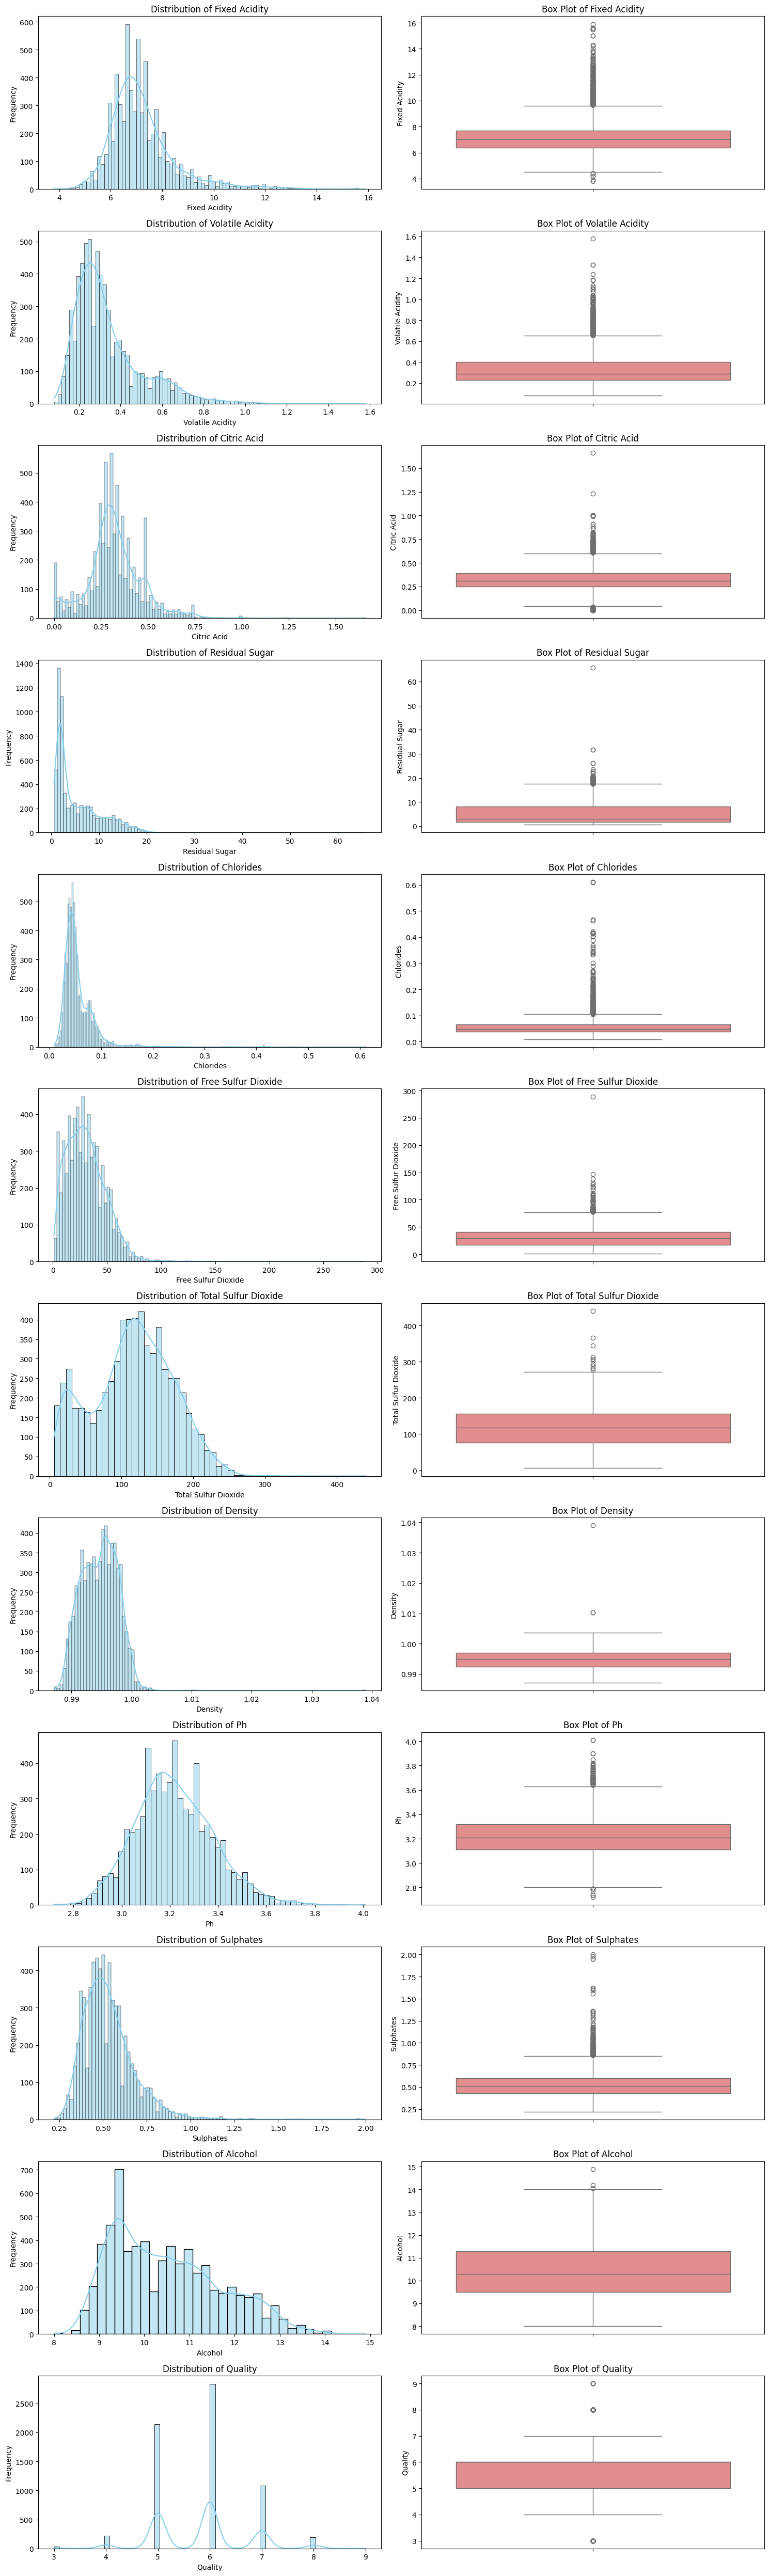

In [5]:
#create a list of varaibles to analyze
wine_quality_variables = wine_quality.columns.tolist()
wine_quality_variables.remove('color')

#create a plot for the distribution of each numeric varaible
plt.figure(figsize=(15, 50))
for i, col in enumerate(wine_quality_variables):
    plt.subplot(len(wine_quality_variables), 2, 2*i + 1)
    sns.histplot(wine_quality[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col.replace("_", " ").title()}')
    plt.xlabel(col.replace("_", " ").title())
    plt.ylabel('Frequency')

    plt.subplot(len(wine_quality_variables), 2, 2*i + 2)
    sns.boxplot(y=wine_quality[col], color='lightcoral')
    plt.title(f'Box Plot of {col.replace("_", " ").title()}')
    plt.ylabel(col.replace("_", " ").title())

plt.tight_layout()
plt.show()

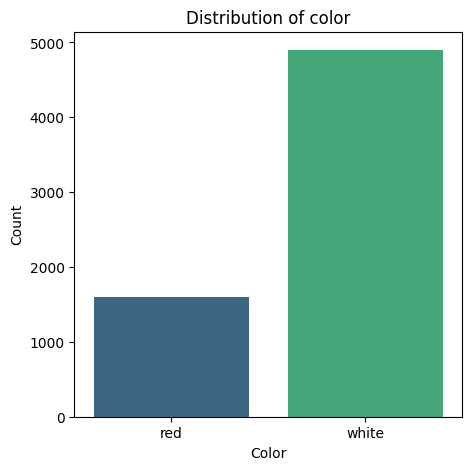

In [6]:
#create plot for distribution of colors
plt.figure(figsize=(5,5))
sns.countplot(x=wine_quality['color'], hue=wine_quality['color'], palette='viridis', legend=False)
plt.title('Distribution of color')
plt.xlabel('Color')
plt.ylabel('Count')

plt.show()

In [7]:
#separating dataframe into 2 for red and white wine
red_wine_data = wine_quality[wine_quality['color'] == 'red']
red_wine_data.head()

,color,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,red,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,red,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,red,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,red,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,red,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [8]:
#correlation matrix for red wine
red_correlation_matrix = red_wine_data[wine_quality_variables].corr(method='pearson')

print('Correlation Matrix')
print(red_correlation_matrix)

Correlation Matrix
                      fixed_acidity  volatile_acidity  citric_acid  \
fixed_acidity              1.000000         -0.256131     0.671703   
volatile_acidity          -0.256131          1.000000    -0.552496   
citric_acid                0.671703         -0.552496     1.000000   
residual_sugar             0.114777          0.001918     0.143577   
chlorides                  0.093705          0.061298     0.203823   
free_sulfur_dioxide       -0.153794         -0.010504    -0.060978   
total_sulfur_dioxide      -0.113181          0.076470     0.035533   
density                    0.668047          0.022026     0.364947   
pH                        -0.682978          0.234937    -0.541904   
sulphates                  0.183006         -0.260987     0.312770   
alcohol                   -0.061668         -0.202288     0.109903   
quality                    0.124052         -0.390558     0.226373   

                      residual_sugar  chlorides  free_sulfur_dioxide  

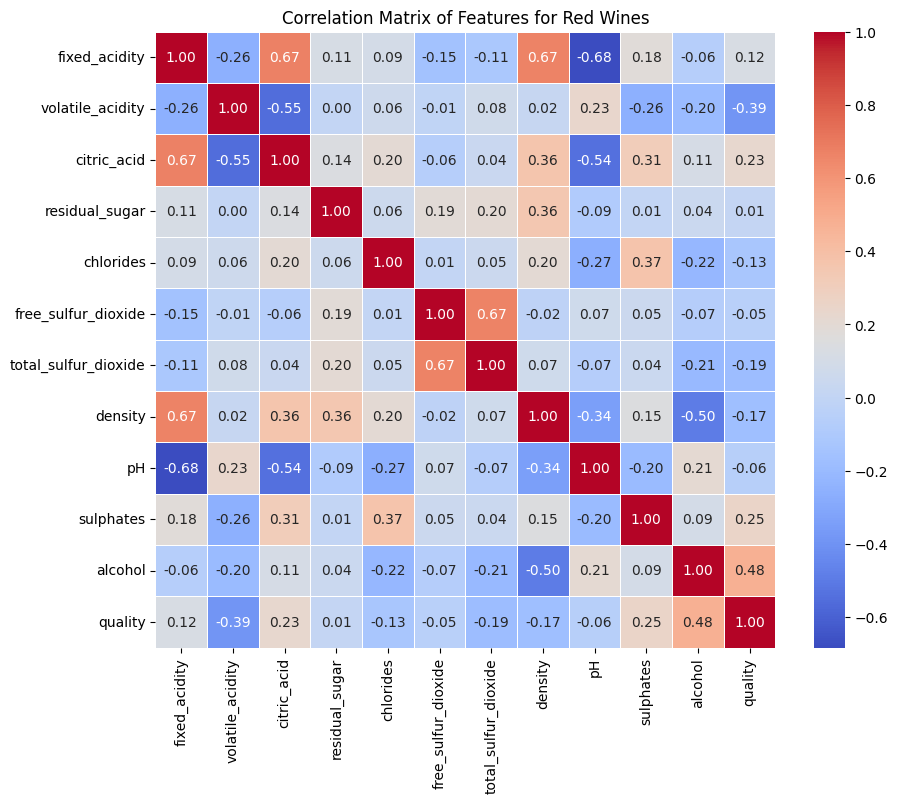

In [9]:
#correlation matrix plot for red wines
plt.figure(figsize=(10, 8))
sns.heatmap(red_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Features for Red Wines')
plt.show()


--- Features Most Correlated with Quality ---

quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric_acid             0.226373
fixed_acidity           0.124052
residual_sugar          0.013732
free_sulfur_dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total_sulfur_dioxide   -0.185100
volatile_acidity       -0.390558
Name: quality, dtype: float64

--- Highly Correlated Features ---

['alcohol', 'volatile_acidity', 'sulphates', 'citric_acid', 'total_sulfur_dioxide', 'density', 'chlorides', 'fixed_acidity', 'pH', 'free_sulfur_dioxide', 'residual_sugar']


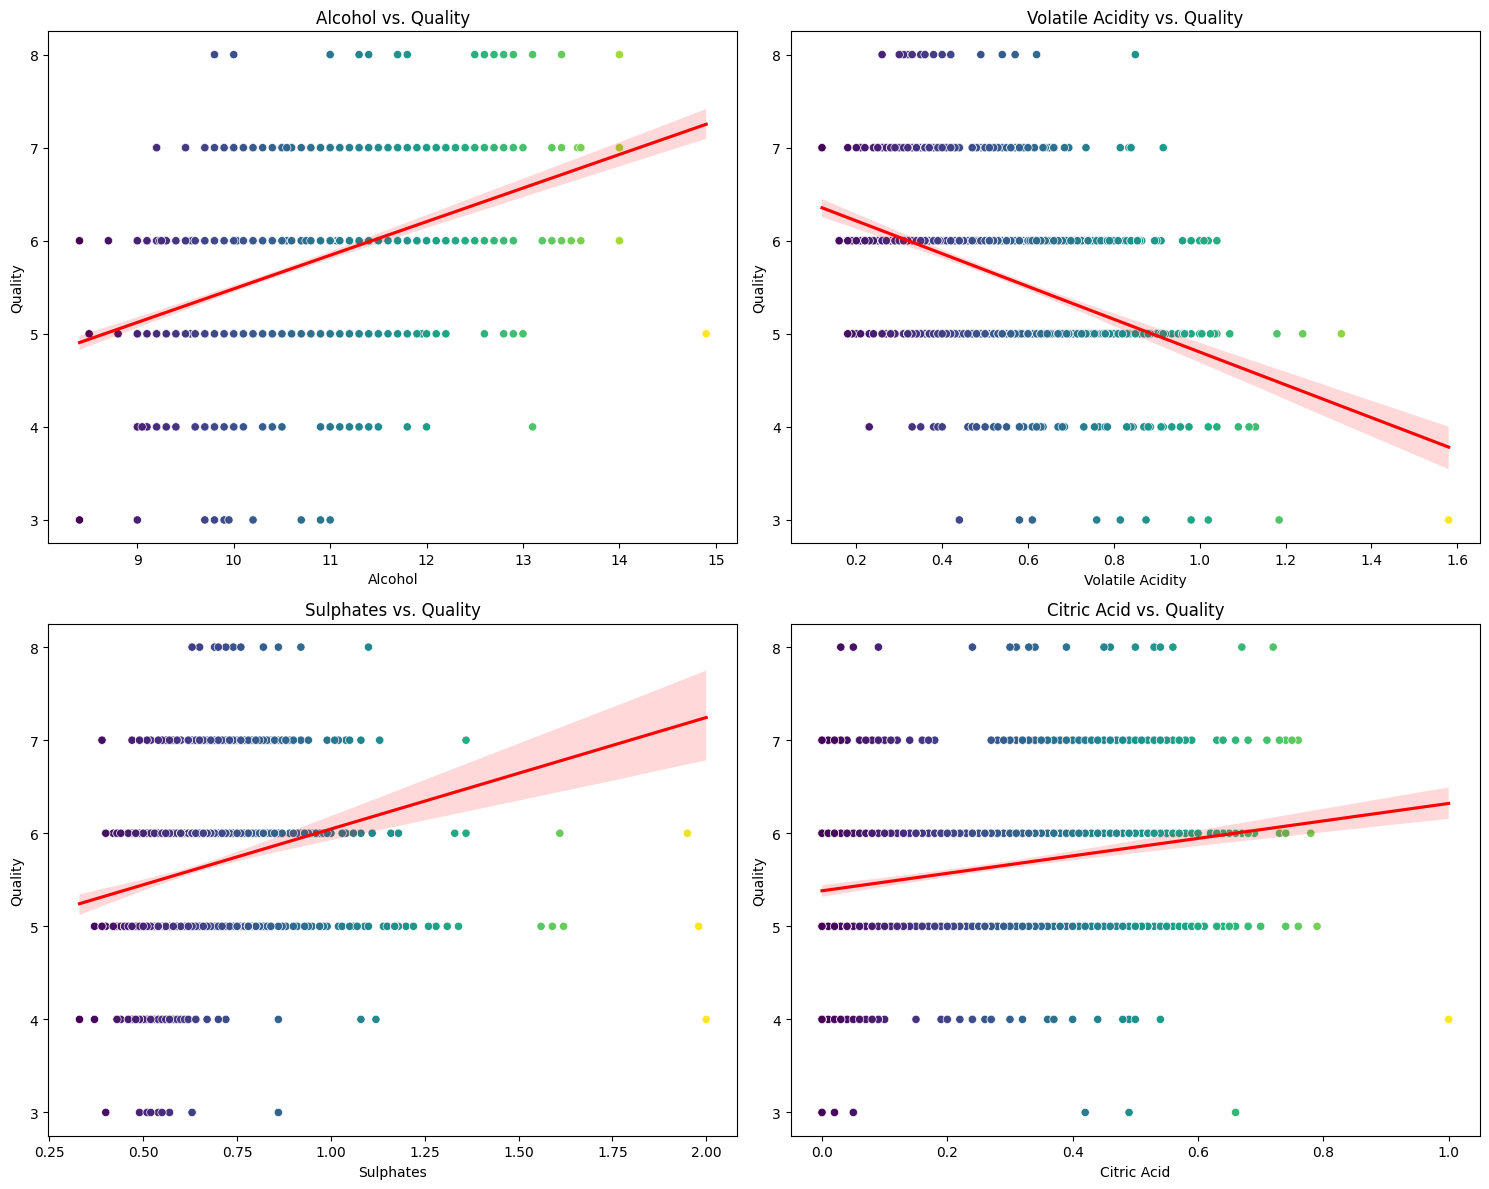

In [10]:
#sort correlation matrix by highest correlation to quality
red_wine_correlations = red_correlation_matrix['quality'].sort_values(ascending=False)
print('\n--- Features Most Correlated with Quality ---\n')
print(red_wine_correlations)

#print the variables in order of correlation to quality
red_highly_correlated_features = red_wine_correlations.drop('quality').abs().sort_values(ascending=False).index.tolist()
print('\n--- Highly Correlated Features ---\n')
print(red_highly_correlated_features)
red_selected_features_for_scatter = red_highly_correlated_features[:4]

#plot the 4 most correlated varaibles
plt.figure(figsize=(15, 12))
for i, feature in enumerate(red_selected_features_for_scatter):
    plt.subplot(2, 2, i + 1)
    sns.scatterplot(x=red_wine_data[feature], y=red_wine_data['quality'], hue=red_wine_data[feature], palette='viridis', legend=False)
    sns.regplot(x=red_wine_data[feature], y=red_wine_data['quality'], scatter=False, color='red')
    plt.title(f'{feature.replace("_", " ").title()} vs. Quality')
    plt.xlabel(feature.replace("_", " ").title())
    plt.ylabel('Quality')

plt.tight_layout()
plt.show()

In [11]:
#create a list of variables related to quality aside from color and quality
numeric = red_wine_data.columns.tolist()
numeric.remove('color')
numeric.remove('quality')
print(numeric)

['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']


In [12]:
target = "quality"
drop_features = "color"

X_red = red_wine_data.drop(columns=[target, drop_features])
y_red = red_wine_data[target]

#split data 80/20 for train and test data
X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(
    X_red, y_red, test_size=0.2, random_state=42
)

numeric_features = numeric

#create preprocessor
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features),
    ]
)

#setting up for model testing
models = {
    "Dummy(mean)": DummyRegressor(strategy="mean"),
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "RandomForest": RandomForestRegressor(
        n_estimators=400, random_state=42, n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "SVM": svm.SVC()
}

#pick scoring methods
scoring = {
    "rmse": "neg_root_mean_squared_error",
    "r2": "r2"
}

#model testing
results = []
for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])
    cv = cross_validate(pipe, X_red_train, y_red_train, cv=5, scoring=scoring, error_score='raise')
    results.append({
        "model": name,
        "cv_rmse_mean": -cv["test_rmse"].mean(),
        "cv_rmse_std": cv["test_rmse"].std(),
        "cv_r2_mean": cv["test_r2"].mean(),
    })

#print results for each model
red_results_df = pd.DataFrame(results).sort_values("cv_rmse_mean")
red_results_df

,model,cv_rmse_mean,cv_rmse_std,cv_r2_mean
4,RandomForest,0.603997,0.041711,0.434286
5,GradientBoosting,0.637738,0.037968,0.369979
3,Lasso,0.661233,0.042082,0.323383
2,Ridge,0.662018,0.041737,0.321810
1,Linear,0.662052,0.041753,0.321739
6,SVM,0.698427,0.055715,0.246037
0,Dummy(mean),0.807490,0.022484,-0.008330


In [13]:
#create white wine dataframe
white_wine_data = wine_quality[wine_quality['color']=='white'].reset_index(drop=True)
white_wine_data.head()

,color,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [14]:
#white wine correlation matrix
white_correlation_matrix = white_wine_data[wine_quality_variables].corr(method='pearson')

print('Correlation Matrix')
print(white_correlation_matrix)

Correlation Matrix
                      fixed_acidity  volatile_acidity  citric_acid  \
fixed_acidity              1.000000         -0.022697     0.289181   
volatile_acidity          -0.022697          1.000000    -0.149472   
citric_acid                0.289181         -0.149472     1.000000   
residual_sugar             0.089021          0.064286     0.094212   
chlorides                  0.023086          0.070512     0.114364   
free_sulfur_dioxide       -0.049396         -0.097012     0.094077   
total_sulfur_dioxide       0.091070          0.089261     0.121131   
density                    0.265331          0.027114     0.149503   
pH                        -0.425858         -0.031915    -0.163748   
sulphates                 -0.017143         -0.035728     0.062331   
alcohol                   -0.120881          0.067718    -0.075729   
quality                   -0.113663         -0.194723    -0.009209   

                      residual_sugar  chlorides  free_sulfur_dioxide  

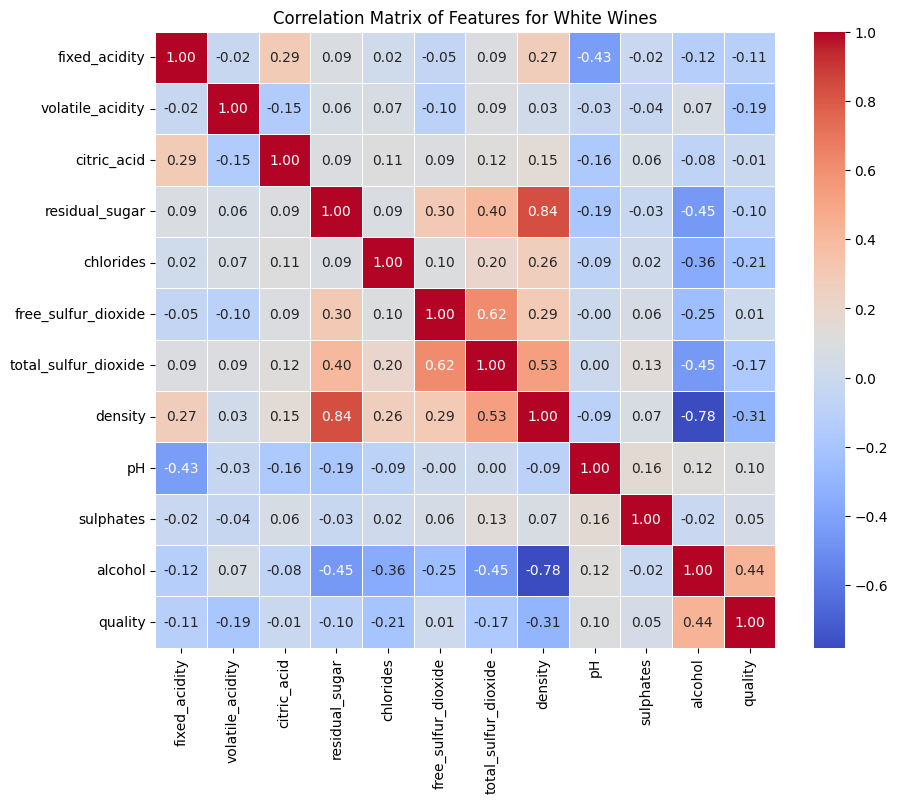

In [15]:
#white wine correlation matrix diagram
plt.figure(figsize=(10, 8))
sns.heatmap(white_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Features for White Wines')
plt.show()


--- Features Most Correlated with Quality ---

quality                 1.000000
alcohol                 0.435575
pH                      0.099427
sulphates               0.053678
free_sulfur_dioxide     0.008158
citric_acid            -0.009209
residual_sugar         -0.097577
fixed_acidity          -0.113663
total_sulfur_dioxide   -0.174737
volatile_acidity       -0.194723
chlorides              -0.209934
density                -0.307123
Name: quality, dtype: float64

--- Highly Correlated Features ---

['alcohol', 'density', 'chlorides', 'volatile_acidity', 'total_sulfur_dioxide', 'fixed_acidity', 'pH', 'residual_sugar', 'sulphates', 'citric_acid', 'free_sulfur_dioxide']


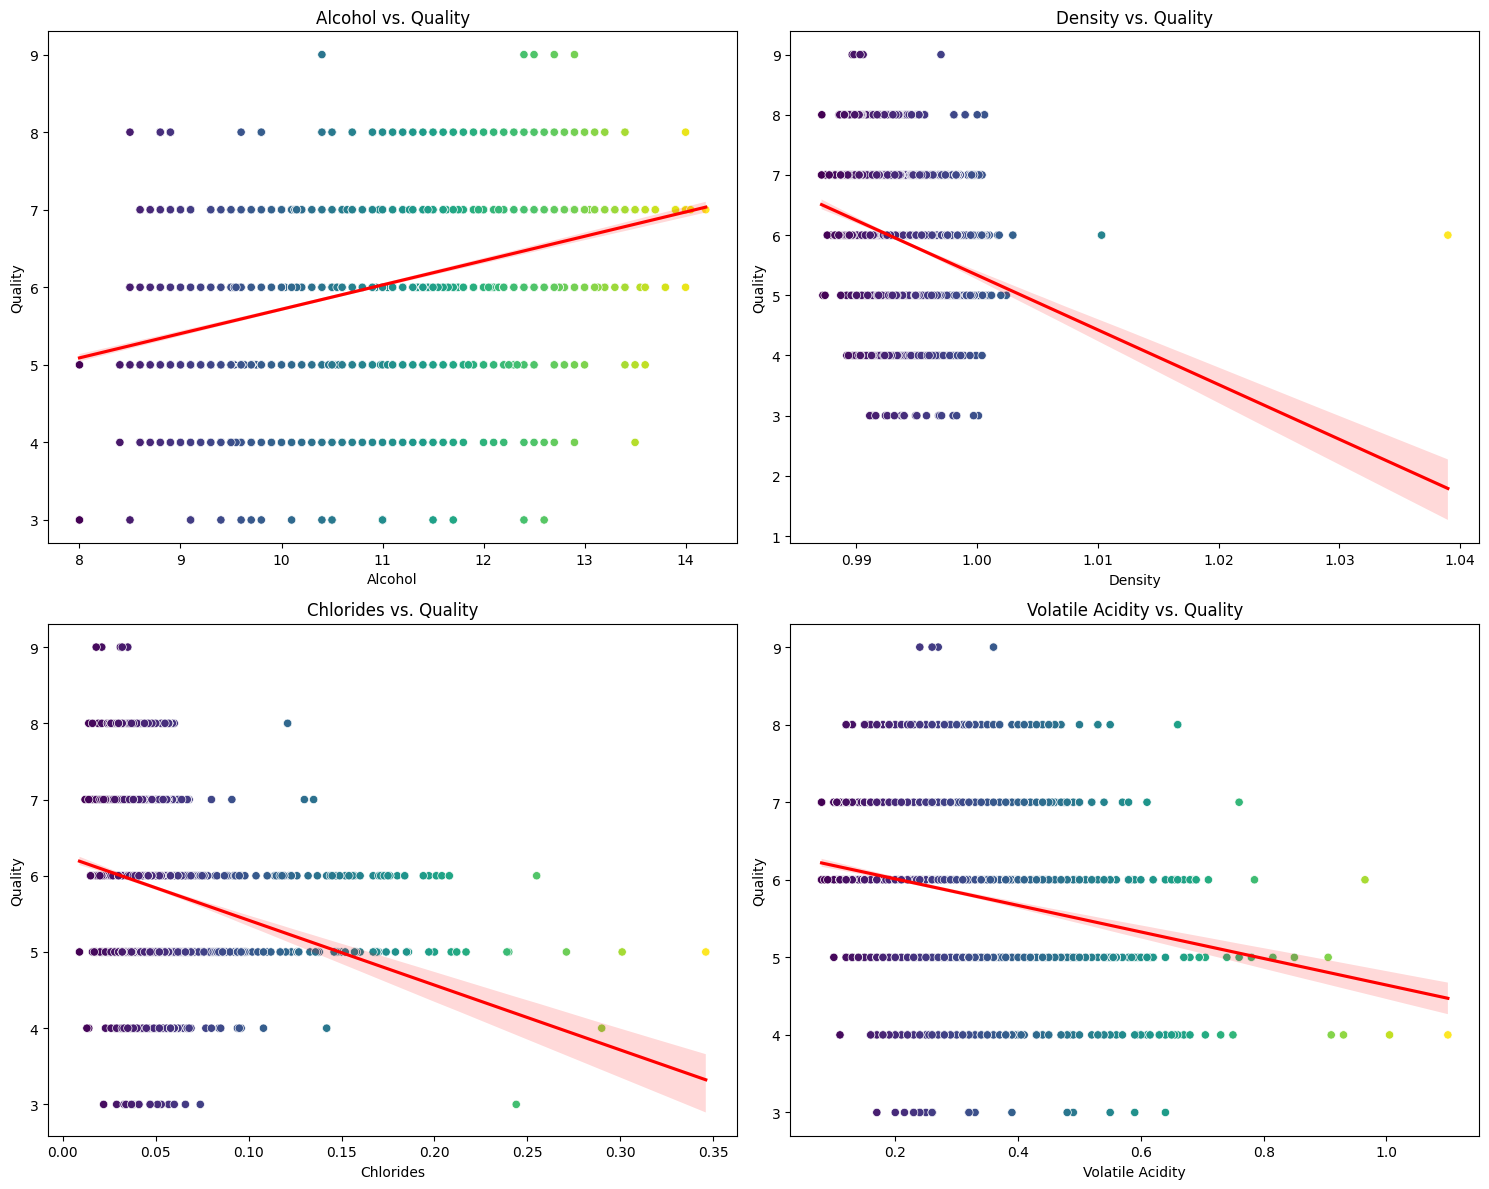

In [16]:
#print features ranked by correlation
white_wine_correlations = white_correlation_matrix['quality'].sort_values(ascending=False)
print('\n--- Features Most Correlated with Quality ---\n')
print(white_wine_correlations)

#print out features in order of correlation
white_highly_correlated_features = white_wine_correlations.drop('quality').abs().sort_values(ascending=False).index.tolist()
print('\n--- Highly Correlated Features ---\n')
print(white_highly_correlated_features)
white_selected_features_for_scatter = white_highly_correlated_features[:4]

#plot 4 most highly correlated features vs quality
plt.figure(figsize=(15, 12))
for i, feature in enumerate(white_selected_features_for_scatter):
    plt.subplot(2, 2, i + 1)
    sns.scatterplot(x=white_wine_data[feature], y=white_wine_data['quality'], hue=white_wine_data[feature], palette='viridis', legend=False)
    sns.regplot(x=white_wine_data[feature], y=white_wine_data['quality'], scatter=False, color='red')
    plt.title(f'{feature.replace("_", " ").title()} vs. Quality')
    plt.xlabel(feature.replace("_", " ").title())
    plt.ylabel('Quality')

plt.tight_layout()
plt.show()

In [17]:
target = "quality"
drop_features = "color"

X_white = white_wine_data.drop(columns=[target, drop_features])
y_white = white_wine_data[target]

#split train and test data 80/20
X_white_train, X_white_test, y_white_train, y_white_test = train_test_split(
    X_white, y_white, test_size=0.2, random_state=42
)

#model analysis for white wine using same preprocessor and models
#as for red wine
results = []
for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])
    cv = cross_validate(pipe, X_white_train, y_white_train, cv=5, scoring=scoring, error_score='raise')
    results.append({
        "model": name,
        "cv_rmse_mean": -cv["test_rmse"].mean(),
        "cv_rmse_std": cv["test_rmse"].std(),
        "cv_r2_mean": cv["test_r2"].mean(),
    })

white_results_df = pd.DataFrame(results).sort_values("cv_rmse_mean")
white_results_df

,model,cv_rmse_mean,cv_rmse_std,cv_r2_mean
4,RandomForest,0.629203,0.021723,0.494941
5,GradientBoosting,0.694765,0.008813,0.384865
2,Ridge,0.753203,0.013251,0.277219
1,Linear,0.753253,0.013276,0.277126
3,Lasso,0.754890,0.012983,0.273956
6,SVM,0.775504,0.013394,0.234996
0,Dummy(mean),0.887145,0.010985,-0.002598
